## Problem 1
In problem set 1, we found solutions to least-squares regression using the closed form solution to
$$
\|X w-y\|_{2}^{2}
$$
Where $X$ is the data, $y$ is the targets, and $w$ are the weights/coefficients. Sometimes when developing a model, it may be a good idea to check that the gradients determined by PyTorch are what we expect. We will now do this in a linear regression setting.


### 1.1 
First, show that
$$
\nabla_{w}\|X w-y\|_{2}^{2}=2 X^{T} X w-2 X^{T} y
$$



$$\nabla_{w}\|X w-y\|_{2}^{2}=\frac{\partial}{\partial w}(X w-y)^{\top}(X w-y)=\frac{\partial}{\partial w}\left(w^{\top} X^{\top} X w-(X w)^{\top} y-y^{\top} X w+y^{\top} y\right)\\=\frac{\partial}{\partial w}\left(w^{\top} X^{\top} X w-2 w^{\top} X^{\top} y+y^{\top} y\right)=2 X^{\top} X w-2 X^{\top} y$$

### 1.2 
Using PyTorch’s autograd functionality, check that the gradient (at the initial weights) with respect to w is the same as what we expect from the closed form solution of the gradient above. To do this, complete p1.py and include the finished version with your submission.

In [ ]:
# p1.py
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from sklearn.datasets import fetch_california_housing
# import sample data
housing = fetch_california_housing()
m,n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]
X = torch.Tensor(housing['data'])
y = torch.Tensor(housing['target']).unsqueeze(1)
# create the weight vector
w_init = torch.randn(8,1,requires_grad=True)

In [ ]:
# TO DO:
# a) calculate closed form gradient with respect to the weights
grad_w1 = 2 * X.T @ X @ w_init - 2 * X.T @ y
grad_w1

tensor([[ 1.5484e+07],
        [ 9.1137e+07],
        [ 2.1032e+07],
        [ 4.2560e+06],
        [ 1.1360e+10],
        [ 1.7788e+07],
        [ 1.4088e+08],
        [-4.7522e+08]], grad_fn=<SubBackward0>)

In [ ]:
# b) calculate gradient with respect to the weights w using autograd # first create the activation function
# print(w_init)
if w_init.grad:
  w_init.grad.data.zero_()
loss = torch.pow((X @ w_init - y), 2).sum()
loss.backward()
print(w_init.grad)

tensor([[ 1.5484e+07],
        [ 9.1137e+07],
        [ 2.1032e+07],
        [ 4.2560e+06],
        [ 1.1360e+10],
        [ 1.7788e+07],
        [ 1.4088e+08],
        [-4.7522e+08]])


In [ ]:
# c) check that the two are equal
print(w_init.grad == grad_w1)
print(torch.abs(w_init.grad - grad_w1) / torch.abs(grad_w1))

# optimizer = torch.optim.SGD([w_init], lr=1e-2, momentum=0.9)
# optimizer.step()

# print(w2)

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False]])
tensor([[6.4584e-07],
        [1.7556e-07],
        [3.8038e-07],
        [2.3496e-07],
        [9.9155e-07],
        [1.1243e-07],
        [0.0000e+00],
        [3.3669e-07]], grad_fn=<DivBackward0>)


The reason why 

```
print(w_init.grad == grad_w1)
```
returns false is because of the precision. We computed their relative difference and found the difference is very small (<10e-7). Therefore, we conclude that the gradient is the same as we expected. 



## Problem 2

### 2.1
It’s tempting to use gradient descent to try to learn good values for hyper-parameters such as $\lambda$ and $\eta$. Can you think of an obstacle to using gradient descent to determine $\lambda$? Can you think of an obstacle to using gradient descent to determine $\eta$?


We can't use gradient descent to optimize $\lambda$ because $\lambda$ is in a seperate term in the objective function. If we to minimize the objective function with respect to $\lambda$, then $\lambda$ will become 0 and there won't be regulariztaion.

We can't use gradient descent on $\eta$ either because $\eta$ isn't even part of the objective function.

### 2.2
L2 regularization sometimes automatically gives us something similar to the new approach to weight initialization (i.e., we initialize the weights as Gaussian random variables with mean 0 and standard deviation $1 / \sqrt{n_{i n}}$ where $n_{in}$ is the number inputs to a neuron). Suppose we are using the old approach to weight initialization (i.e., we initialize the weights as Gaussian random variables with mean 0 and standard deviation 1). Sketch a heuristic argument that:

(a) Supposing $\lambda$ is not too small, the first epochs of training will be dominated almost entirely by weight decay.

(b) Provided $\eta\lambda \ll n$ the weights will decay by a factor of $exp(−\eta\lambda/m)$ per epoch.

(c) Supposing $\lambda$ is not too large, the weight decay will tail off when the weights are down to a size
around $1 / \sqrt{n}$, where $n$ is the total number of weights in the network.

#### (a) 
Suppose $\lambda$ is not too small. NNDL Chapter 3 Formula 87 shows that 

$$C=C_{0}+\frac{\lambda}{2 n} \sum_{w} w^{2}$$

where $C_0$ is the original, unregularized cost function. When $\lambda$ is not too small, the second dominates the cost function. Therefore, the first epochs of training will be dominated almost entirely by weight decay. 



#### (b)
Based on the SGD update rule, 
$$w \rightarrow\left(1-\frac{\eta \lambda}{n}\right) w-\frac{\eta}{m} \sum_{x} \frac{\partial C_{x}}{\partial w}$$.

Since $\left(1-\frac{\eta \lambda}{n}\right) \in [0,1]$, every time after it finishs a mini-batch, the weight will decay. The total decay time is the $\frac{n}{m}$, where $n$ is the size of the training set and $m$ is the size of the mini-batch. Therefore, after an epoch, the weight get decayed by $\left(1-\frac{\eta \lambda}{n}\right) ^ \frac{n}{m}$.

We know that $\lim _{n \rightarrow \infty}\left(1+\frac{1}{n}\right)^{n}=e$. Therefore, 
$$\lim _{n \rightarrow \infty}\left(1-\frac{1}{n}\right)^{-n} = \lim _{n \rightarrow \infty}\left((\frac{n-1}{n})^{-1}\right)^{n}=\lim _{n \rightarrow \infty}(\frac{n}{n-1})^{n}=\lim _{n \rightarrow \infty}(\frac{n-1+1}{n-1})^{n}
=\lim _{n \rightarrow \infty}(1+\frac{1}{n-1})^{n-1+1}
=\lim _{n \rightarrow \infty}(1+\frac{1}{n-1})^{n-1}(1+\frac{1}{n-1}) = e$$


Suppose $\eta\lambda \ll n$, then $\frac{n}{\eta \lambda}\rightarrow \infty.$

Therefore, $\left(1-\frac{\eta \lambda}{n}\right) ^ \frac{n}{m} = \left(1-\frac{\eta \lambda}{n}\right)^{\left(-\frac{n}{\eta \lambda}\right) \left(-\frac{\eta \lambda}{m}\right)} \rightarrow e ^ \left(-\frac{\eta \lambda}{m}\right)$.




#### (c) 
Suppose we initilize the weights with mean 0 and standard deviation 1. It will probably cause neuron to saturate. This is because, for example, the number of input neurons is 1024 and output has mean 0 and standard deviation is $\sqrt{1024}$. Given the sigmoid function, the gradient will vainish. Hence, with L2 regularization, the gradient of the regulizartion term will dominate the gradient of the objective function, which makes the weight decay. When the weights shrink to some specific point, the neurons become not saturated and the gradient of the loss function will dominate the gradient of the regulaizartion term. This is the point where weight decay tails off.

As to what is this specific point, we can assume all the input neuron are 1 and the standard deviation of the weights is $\sigma$. Then the variance of output neuron is $n\sigma^2$. Then its standard deviation is $\sqrt{n\sigma^2}$. When we need unsaturated neurons, we want the output neuron to have the same scale as the input neuron, i.e. 1, which is within the range of the sigmoid function where the gradient is not zero. Then $\sigma = \frac{1}{\sqrt{n}}$. 

## Problem 3

### 3.1
Autoencoders learn to recreate their input after passing it through a sequence of layers in a neural network. This goal can be satisfied by simply learning the identity function. What design choices can be made (e.g. about the network architecture) to prevent them from learning the identity function? Pick at least two and discuss why an autoencoder with your design choice would be more useful than one without it.

We can restrict the size of the code (i.e. add a bottleneck). Since the size decrese, the AE won't learn the identity function any more. We can also add regularization. Adding regularization can also modify the loss function to encourage disirable properties, such as parsity, robustness to noise, restrictions on graident sensitivity. 

### 3.2 
In class we discussed denoising autoencoders that learn to correct a corruption process that we model with $C(\hat x \mid x)$. Describe an example of such a corruption process, express it in a formula, and provide a plot of an original two-dimensional dataset (e.g. samples from $y = x^2$ or anything of your choosing) and the same dataset after you’ve corrupted it with your function $C$.

The formula I choose is $y=x^2$. The corrupted data is $y + \epsilon$ where $\epsilon \sim N(0,1)$. The blue dots are original and the red dots are corrupted.

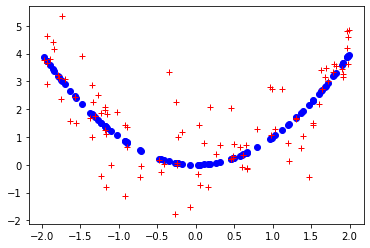

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.uniform(-2,2,100)
y = x ** 2
noise = np.random.normal(0, 1, 100)
corrupted_y = y + noise
plt.plot(x, y, 'bo')
plt.plot(x, corrupted_y, 'r+')
plt.show()

### 3.3 
Build an autoencoder with one hidden layer and two neurons for the MNIST dataset. Plot the embedding layer and color it by the label of each image. Describe what you can learn about this dataset from looking at the points embedded into the latent space of an autoencoder.


In [ ]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

img_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.5], [0.5])
])

num_epochs = 100
batch_size = 128
learning_rate = 1e-3

dataset = MNIST(root='./data', train=True, download=True, transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(28 * 28, 2),
      )
    self.decoder = nn.Sequential(
      nn.Linear(2, 28 * 28),
      )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
  for data in dataloader:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img)
    # forward
    output = model(img)
    loss = criterion(output, img)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(loss.data)
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))

tensor(0.2915)
epoch [1/100], loss:0.2915
tensor(0.2671)
epoch [2/100], loss:0.2671
tensor(0.2700)
epoch [3/100], loss:0.2700
tensor(0.2531)
epoch [4/100], loss:0.2531
tensor(0.2496)
epoch [5/100], loss:0.2496
tensor(0.2498)
epoch [6/100], loss:0.2498
tensor(0.2478)
epoch [7/100], loss:0.2478
tensor(0.2454)
epoch [8/100], loss:0.2454
tensor(0.2320)
epoch [9/100], loss:0.2320
tensor(0.2308)
epoch [10/100], loss:0.2308
tensor(0.2327)
epoch [11/100], loss:0.2327
tensor(0.2442)
epoch [12/100], loss:0.2442
tensor(0.2224)
epoch [13/100], loss:0.2224
tensor(0.2316)
epoch [14/100], loss:0.2316
tensor(0.2245)
epoch [15/100], loss:0.2245
tensor(0.2296)
epoch [16/100], loss:0.2296
tensor(0.2270)
epoch [17/100], loss:0.2270
tensor(0.2218)
epoch [18/100], loss:0.2218
tensor(0.2301)
epoch [19/100], loss:0.2301
tensor(0.2163)
epoch [20/100], loss:0.2163
tensor(0.2087)
epoch [21/100], loss:0.2087
tensor(0.2276)
epoch [22/100], loss:0.2276
tensor(0.2285)
epoch [23/100], loss:0.2285
tensor(0.2211)
epoch

(torch.Size([60000, 28, 28]), torch.uint8)
torch.Size([60000, 2])
torch.Size([60000])


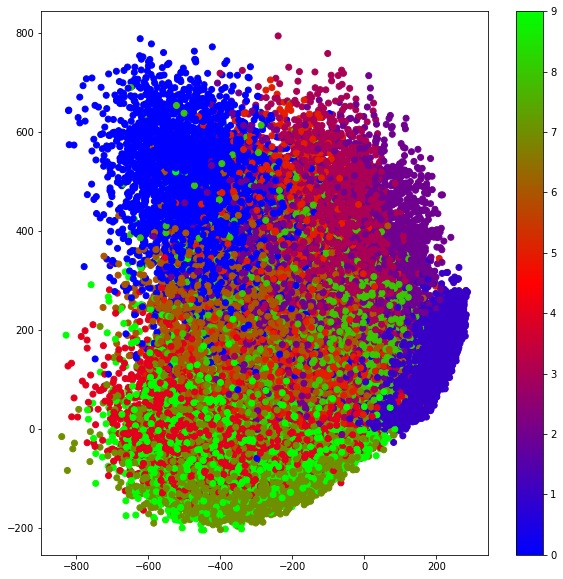

In [ ]:
imgs = dataset.data;
print((imgs.shape, imgs.dtype))
imgs = imgs.view(imgs.size(0), -1)

output = model.encoder(imgs.float())
print(output.shape)

print(dataset.targets.shape)

output1 = output.detach().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(output1[:,0], output1[:,1], c=dataset.targets, cmap='brg')
plt.colorbar()
plt.show()

We should expect that the 9 classes are separated. But it is hard to tell that the classes are separated. Maybe it is because there is only 1 hidden layer.

## Problem 4

### 4.1
Describe the differences between Kullback-Leibler divergence, Jensen-Shannon divergence, MMD, and Wasserstein distance.

They are all common ways of comparing probability distributions. 

- KL divergence is also known as relative entropy. It's not a distance. It's expected number of extra bits needed if using samples from $p$ on a code optimized for $q$. It's not symmetric and possibly infinite when there are points such that $p(x)=0$ and $q(x)>0$.

$$D_{\mathrm{KL}}(p \| q)=\sum_{x \in \mathcal{X}} p(x) \log \left(\frac{p(x)}{q(x)}\right).$$

- JS Divergence is symmetrical and always defined. It's also more smooth.

$$D_{J S}(p \| q)=\frac{1}{2} D_{K L}\left(p \| \frac{p+q}{2}\right)+\frac{1}{2} D_{K L}\left(q \| \frac{p+q}{2}\right)$$

- Wasserstein distance is a measure of the distance between two probability distributions. It is also called Earth Mover’s distance, short for EM distance. Wasserstein is better than JS or KL divergence because even when two distributions are located in lower dimensional manifolds without overlaps, Wasserstein distance can still provide a meaningful and smooth representation of the distance in-between.

$$\begin{aligned}W\left(p, q\right) &= \inf _{\gamma \in \pi} \iint \|x-y\| \gamma(x, y) \mathrm{d} x \mathrm{~d} y \\
&=\inf _{\gamma \in \pi} \mathbb{E}_{x, y \sim \gamma}[\|x-y\|] \\ 
&=\sup _{\|f\|_{L \leq 1}} \mathbb{E}_{x \sim p}[f(x)]-\mathbb{E}_{y \sim q}[f(y)]\end{aligned}$$

where $\pi$ is the set of joint distributions whose marginal distributions are $p_r$ and $p_\theta$.

- MMD distance measures the distance between distributions by distance between the means of the embedded features. It can be written in a similar form as the Kantorovich-Rubinstein duality form (last line in the above equation) of the Wasserstein distance. However, the supremum in the Kantorovich-Rubinstein duality form of the Wasserstein distance is over all the 1-Lipschitz functions while the supremum in the MMD distance is over all the functions in the reproducing kernel Hilbert space whose norm is less than 1.

$$\begin{aligned} \operatorname{MMD}(p, q) 
&=\left\|\mathbb{E}_{x \sim p} \phi(x) - \mathbb{E}_{y \sim q} \phi(y)\right\|_{\mathcal{H}} \\ &=\sup _{\|f\| \leq 1}\left\langle\mathbb{E}_{x \sim p} \phi(x) - \mathbb{E}_{y \sim q}\phi(y), f\right\rangle_{\mathcal{H}} \\ 
&= \sup _{\|f\| \leq 1}\left(\mathbb{E}_{x \sim p}[f(x)]-\mathbb{E}_{y \sim q}[f(y)]\right)\end{aligned}$$



Reference:
- WGAN paper
- https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html
- https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution


### 4.2
Using the skeleton code in vae.py, fill in the TODOs to build a VAE for the MNIST dataset. The code returns a sample of 8 different inputs and their reconstructions for each epoch. Include the reconstruction sample for the first and last epoch in your report. Submit your filled-in version of vae.py along with the assignment.

In [ ]:
!mkdir results
!python vae.py

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.572021
Train Epoch: 1 [1280/60000 (2%)]	Loss: 291.882050
Train Epoch: 1 [2560/60000 (4%)]	Loss: 241.955002
Train Epoch: 1 [3840/60000 (6%)]	Loss: 212.320740
Train Epoch: 1 [5120/60000 (9%)]	Loss: 214.543976
Train Epoch: 1 [6400/60000 (11%)]	Loss: 216.663116
Train Epoch: 1 [7680/60000 (13%)]	Loss: 201.579803
Train Epoch: 1 [8960/60000 (15%)]	Loss: 195.256744
Train Epoch: 1 [10240/60000 (17%)]	Loss: 197.438843
Train Epoch: 1 [11520/60000 (19%)]	Loss: 189.910583
Train Epoch: 1 [12800/60000 (21%)]	Loss: 185.966095
Train Epoch: 1 [14080/60000 (23%)]	Loss: 181.120499
Train Epoch: 1 [15360/60000 (26%)]	Loss: 169.185760
Train Epoch: 1 [16640/60000 (28%)]	Loss: 166.216782
Train Epoch: 1 [17920/60000 (30%)]	Loss: 166.638336
Train Epoch: 1 [19200/60000 (32%)]	Loss: 164.184143
Train Epoch: 1 [20480/60000 (34%)]	Loss: 167.744064
Train Epoch: 1 [21760/60000 (36%)]	Loss: 154.769089
Train Epoch: 1 [23040/60000 (38%)]	Loss: 153.823181
Train Epoch: 1 [24320/60000 

In [ ]:
# # vae.py

# import argparse
# import torch
# import torch.utils.data
# from torch import nn, optim
# from torch.nn import functional as F
# from torchvision import datasets, transforms
# from torchvision.utils import save_image

# parser = argparse.ArgumentParser(description='VAE MNIST Example') # collect arguments passed to file
# parser.add_argument('--batch-size', type=int, default=128, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

# torch.manual_seed(args.seed)

# device = torch.device("cuda" if args.cuda else "cpu") # Use NVIDIA CUDA GPU if available

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
# # # Uncomment these lines (and comment the above) to use the Fashion MNIST dataset
# # train_loader = torch.utils.data.DataLoader(
# #     datasets.FashionMNIST('./data', train=True, download=True,
# #                    transform=transforms.ToTensor()),
# #     batch_size=args.batch_size, shuffle=True, **kwargs)
# # test_loader = torch.utils.data.DataLoader(
# #     datasets.FashionMNIST('./data', train=False, download=True,transform=transforms.ToTensor()),
# #     batch_size=args.batch_size, shuffle=True, **kwargs)


# class VAE(nn.Module):
#     def __init__(self):
#         super(VAE, self).__init__()

#         self.fc1 = nn.Linear(784, 400)
#         self.fc21 = nn.Linear(400, 20)
#         self.fc22 = nn.Linear(400, 20)
#         self.fc3 = nn.Linear(20, 400)
#         self.fc4 = nn.Linear(400, 784)

#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5*logvar)
#         eps = torch.randn_like(std)
#         return mu + eps*std

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))

#     def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, 784))
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar


# model = VAE().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)


# def VAE_loss_function(recon_x, x, mu, logvar):
#     # TO DO: Implement reconstruction + KL divergence losses summed over all elements and batch

#     # see lecture 12 slides for more information on the VAE loss function
#     # for additional information on computing KL divergence
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
    
#     recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + KLD


# def train(epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.to(device)
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         loss = VAE_loss_function(recon_batch, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

#     print('====> Epoch: {} Average loss: {:.4f}'.format(
#           epoch, train_loss / len(train_loader.dataset)))


# def test(epoch):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += VAE_loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))


# if __name__ == "__main__":
#     for epoch in range(1, args.epochs + 1):
#         train(epoch)
#         test(epoch)
#         with torch.no_grad():
#             sample = torch.randn(64, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')

### 4.3 
Retrain your VAE on the Fashion MNIST dataset by un-commenting lines 37-43 in vae.py. Fashion MNIST was designed as a more complex replacement for MNIST. Like MNIST, it contains 70,000 grayscale images of 28 by 28 pixels, but these are divided between ten classes of fashion accessories - sandals, handbags, pullovers – whose variety poses a greater challenge than handwritten digits. Play with the hyperparameters of your VAE to try to generate the best images possible. Include these in your report; they will be needed for comparison in Problem 5.

In [ ]:
!python vae.py --batch-size 64 --epochs 100

26422272it [00:02, 11735888.66it/s]                 
Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw

29696it [00:00, 210859.46it/s]               
Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

4422656it [00:01, 3899263.79it/s]                
Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw

6144it [00:00, 19976592.07it/s]
Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Processing...
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest o

In [ ]:
!mkdir results
!python vae.py --batch-size 64 --epochs 100

mkdir: cannot create directory ‘results’: File exists
Traceback (most recent call last):
  File "vae.py", line 2, in <module>
    import torch
  File "/usr/local/lib/python3.7/dist-packages/torch/__init__.py", line 196, in <module>
    from torch._C import *
ImportError: numpy.core.multiarray failed to import


## Problem 5


### 5.1
Use the skeleton code in gan.py to build a functional GAN. The Generator and Discriminator classes have been provided, but you’ll need to implement a training routine for these classes by filling in the methods train generator and train discriminator.

### 5.2
Run your GAN on the Fashion MNIST dataset. Note: this will take 10-30 minutes or longer if your computer lacks an NVIDIA GPU. Google COLAB provides free GPU enabled runtimes, and could be a good resource.

In [ ]:
!mkdir results

Training Steps Completed:  0
Epoch 0: loss_d: 0.1573270559310913, loss_g: 10.347583770751953
Training Steps Completed:  499
Epoch 1: loss_d: 0.000577775586862117, loss_g: 19.126665115356445
Training Steps Completed:  998
Epoch 2: loss_d: 0.00013595812197308987, loss_g: 25.815505981445312
Training Steps Completed:  1497
Epoch 3: loss_d: 4.5348715502768755e-05, loss_g: 29.597064971923828
Training Steps Completed:  1996
Epoch 4: loss_d: 2.145252437912859e-05, loss_g: 30.904253005981445
Training Steps Completed:  2495
Epoch 5: loss_d: 4.399708996061236e-05, loss_g: 100.0
Training Steps Completed:  2994
Epoch 6: loss_d: 1.005683861876605e-05, loss_g: 100.0
Training Steps Completed:  3493
Epoch 7: loss_d: 5.532331215363229e-06, loss_g: 100.0
Training Steps Completed:  3992
Epoch 8: loss_d: 2.7530670649866806e-06, loss_g: 100.0
Training Steps Completed:  4491
Epoch 9: loss_d: 1.3092727613184252e-06, loss_g: 100.0
Training Steps Completed:  4990
Epoch 10: loss_d: 6.417916438294924e-07, loss_g:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 20: loss_d: 5.5470699145132585e-09, loss_g: 100.0
Training Steps Completed:  10479
Epoch 21: loss_d: 2.4177264634772655e-09, loss_g: 100.0
Training Steps Completed:  10978
Epoch 22: loss_d: 1.842177410615875e-09, loss_g: 100.0
Training Steps Completed:  11477
Epoch 23: loss_d: 8.847581556281625e-10, loss_g: 100.0


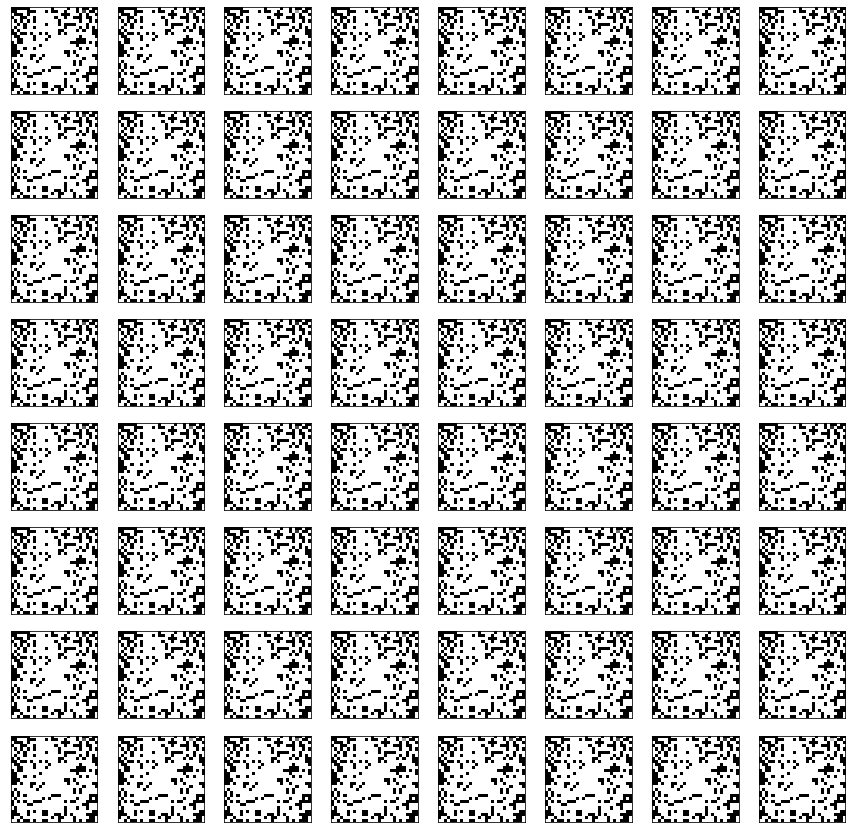

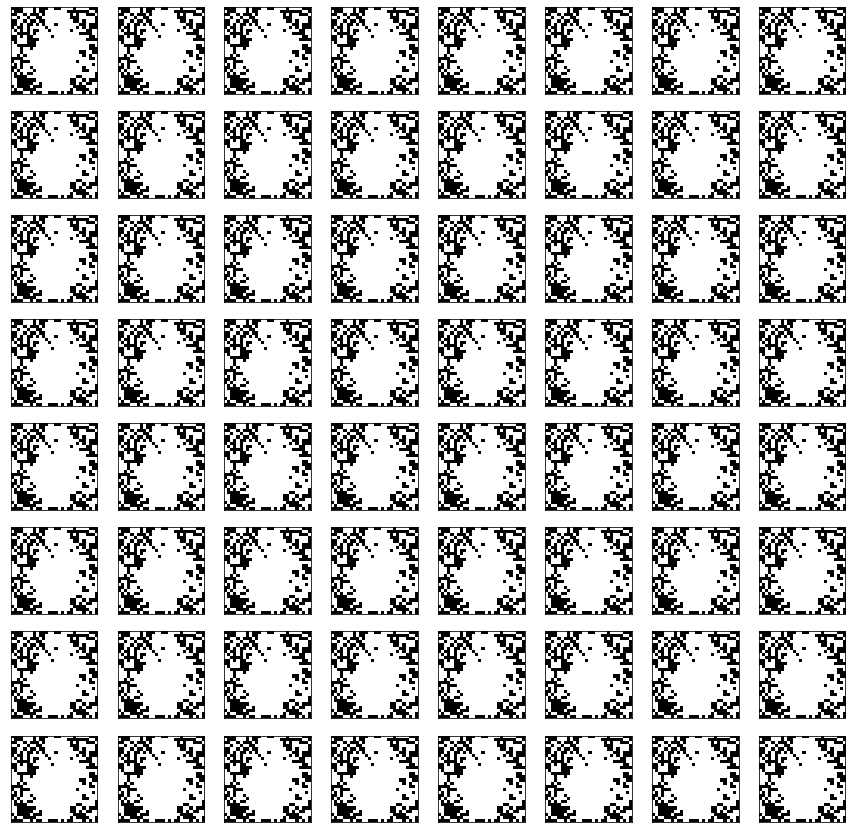

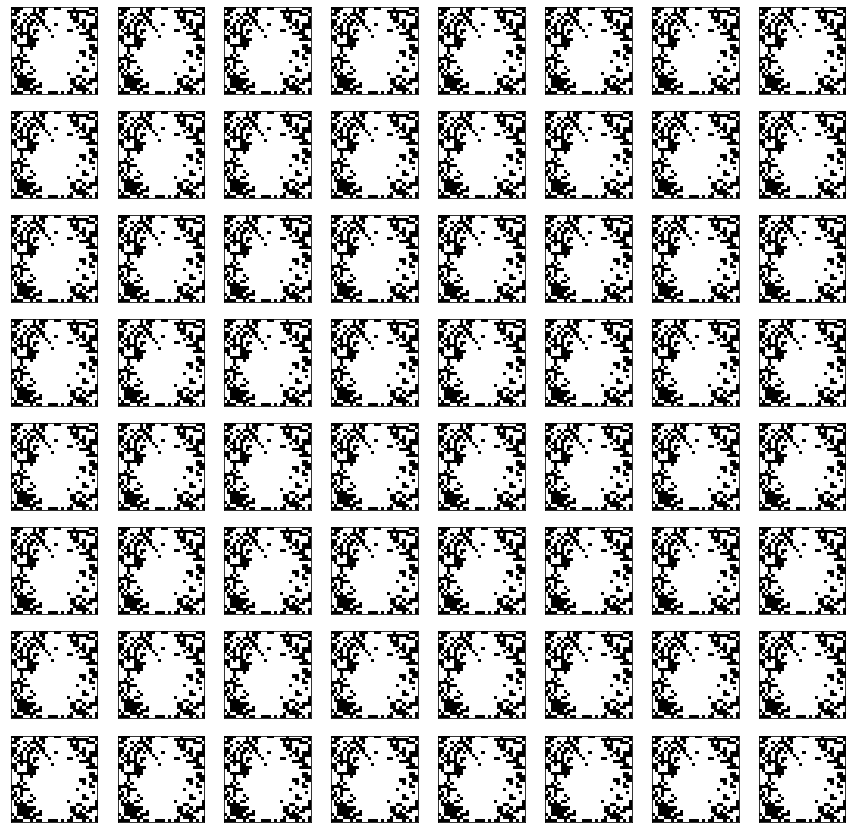

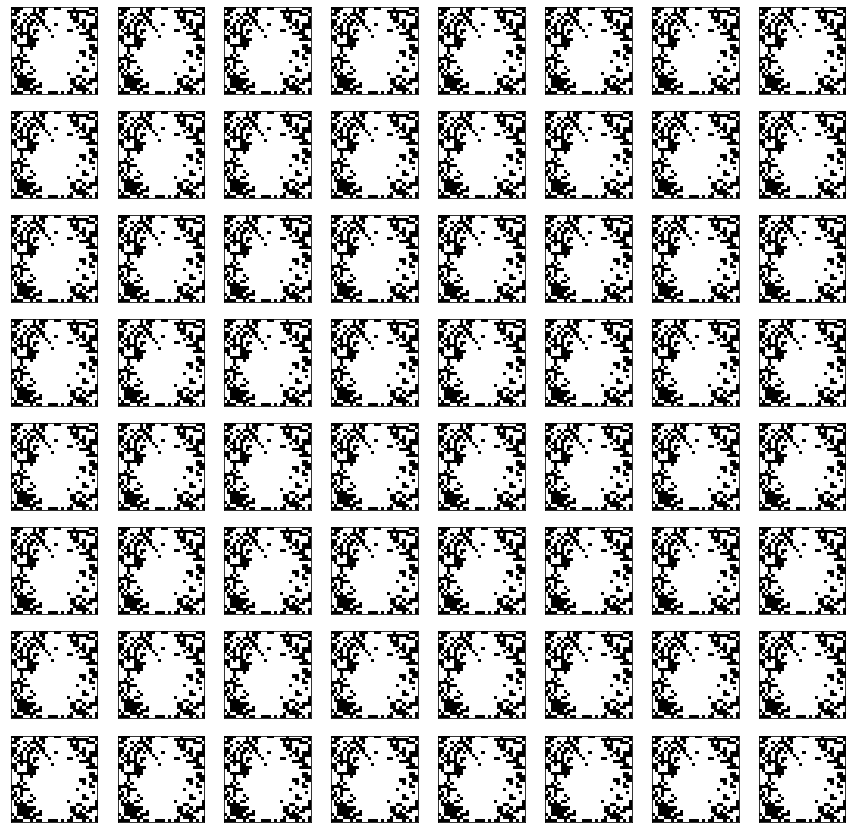

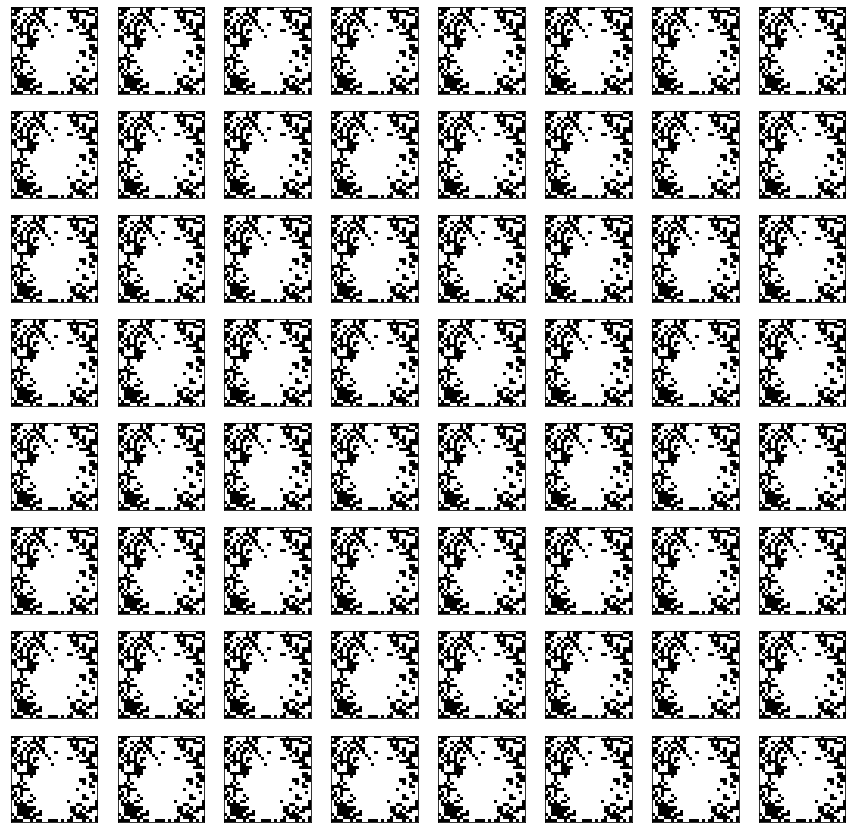

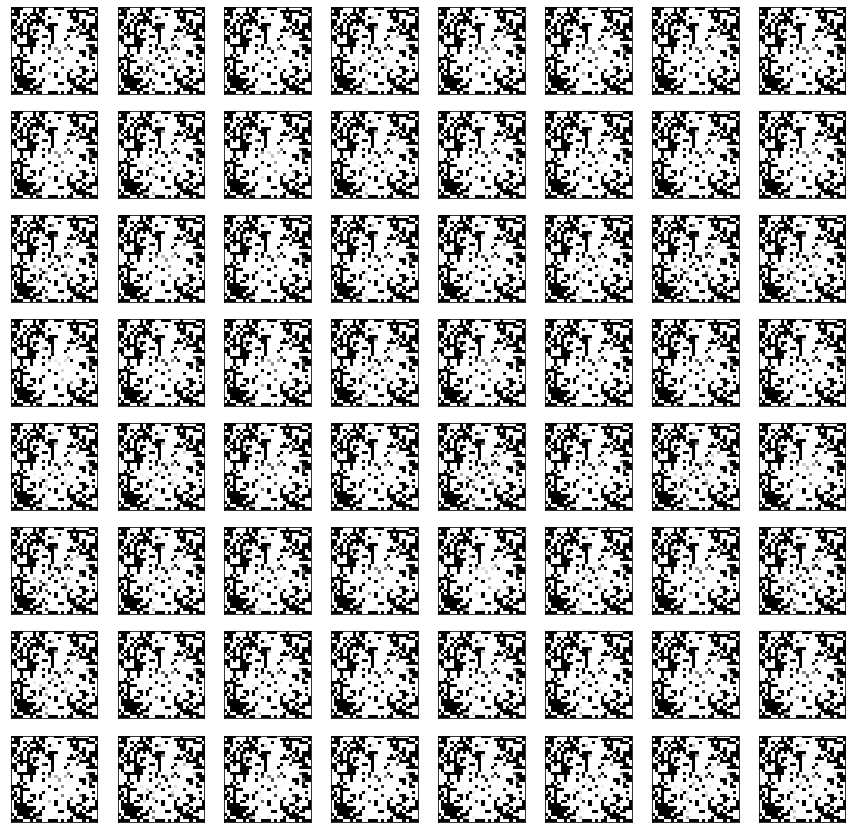

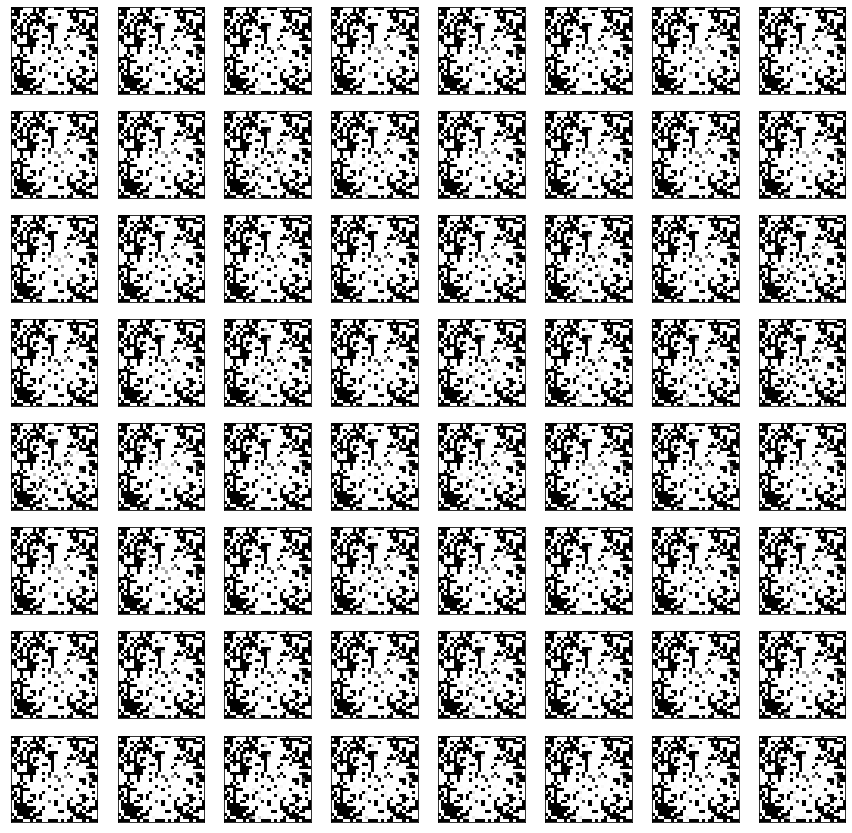

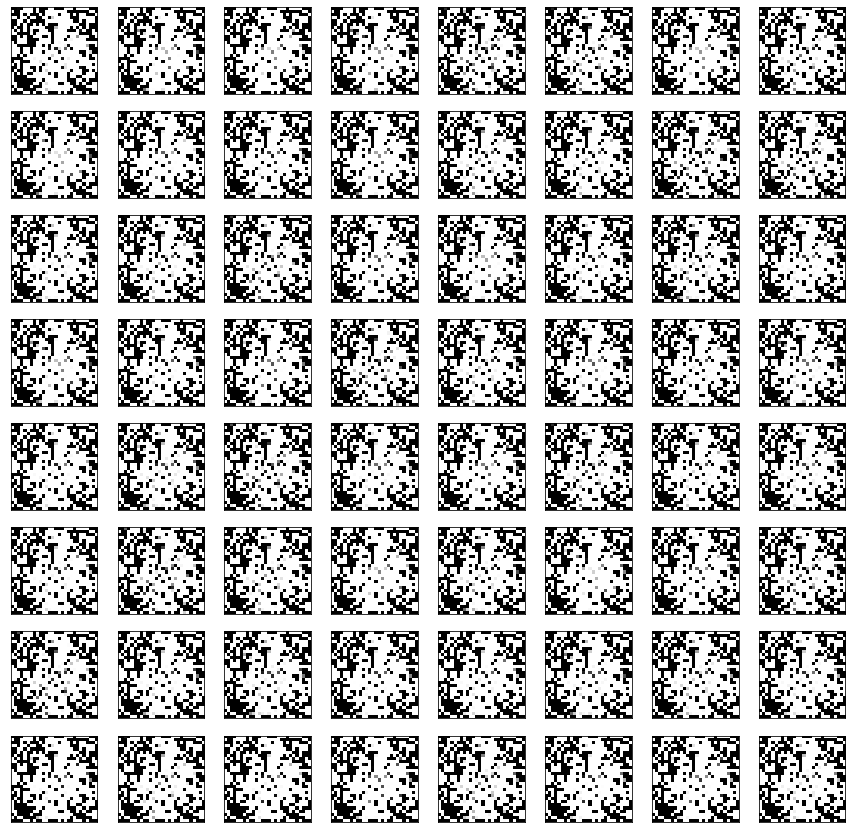

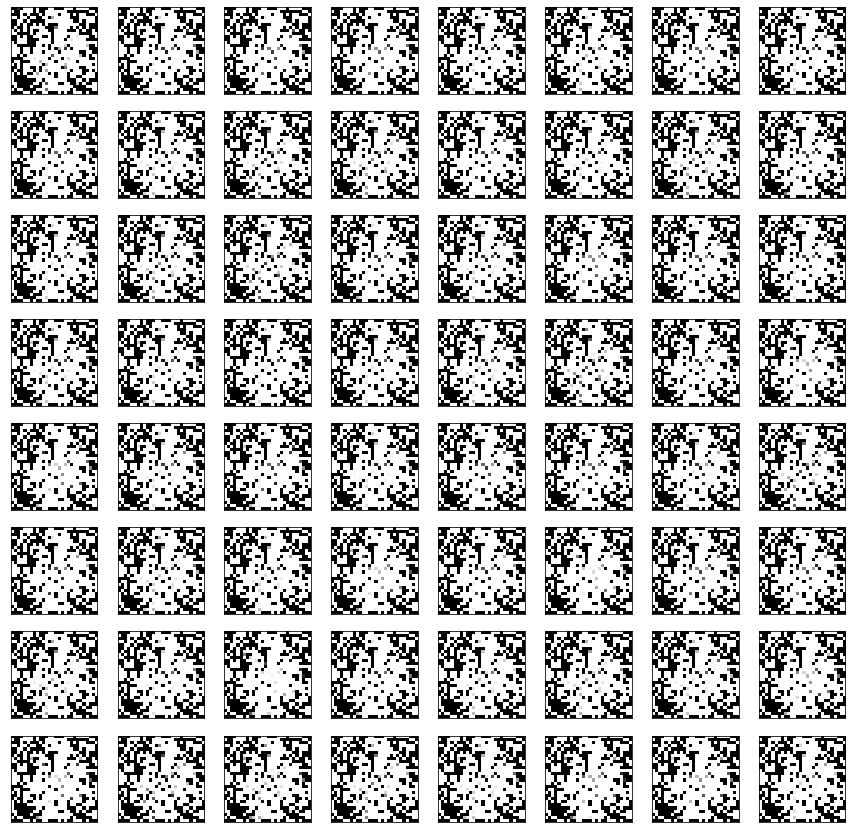

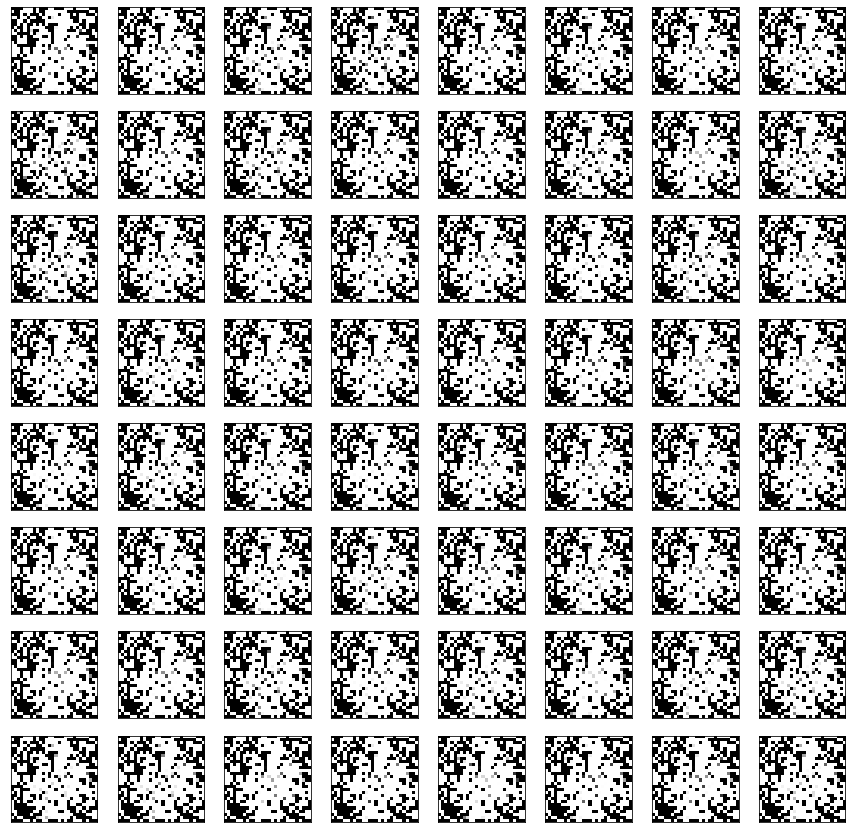

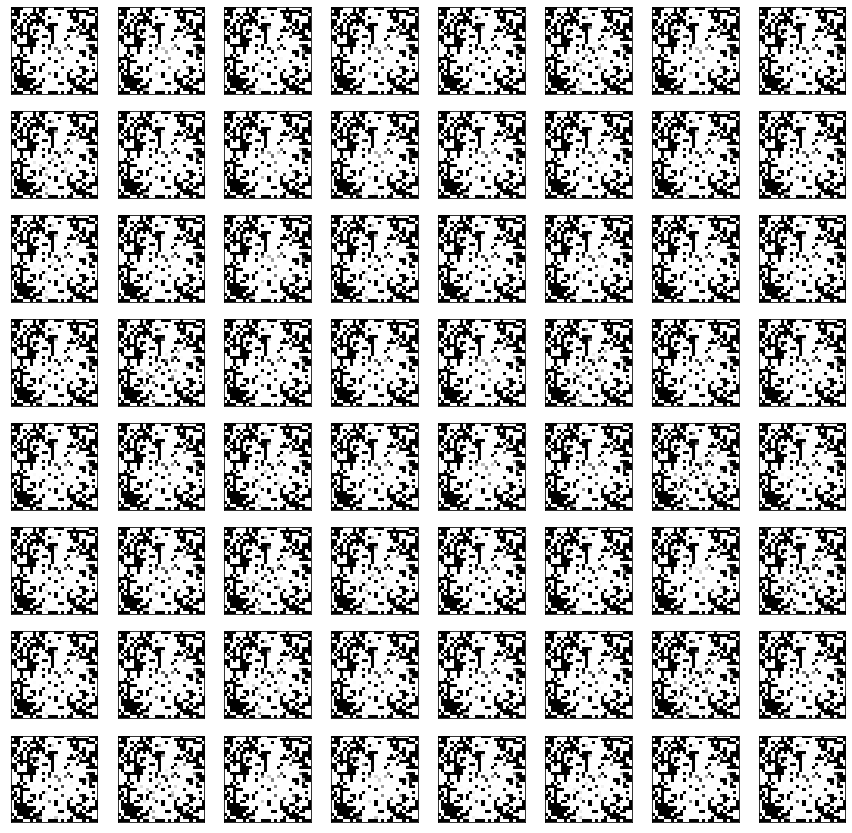

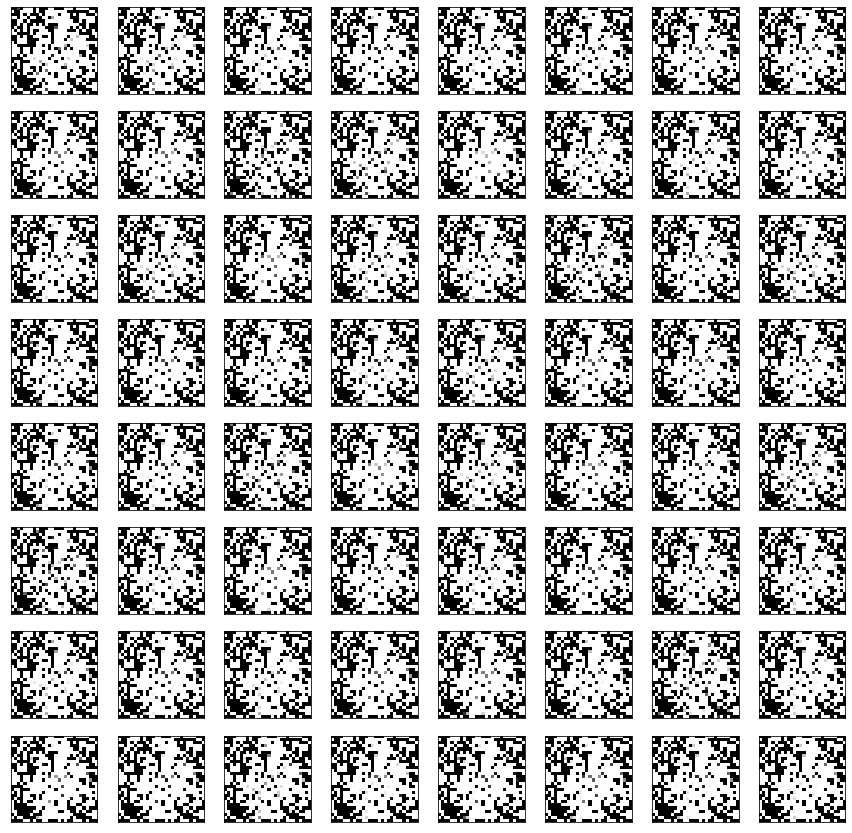

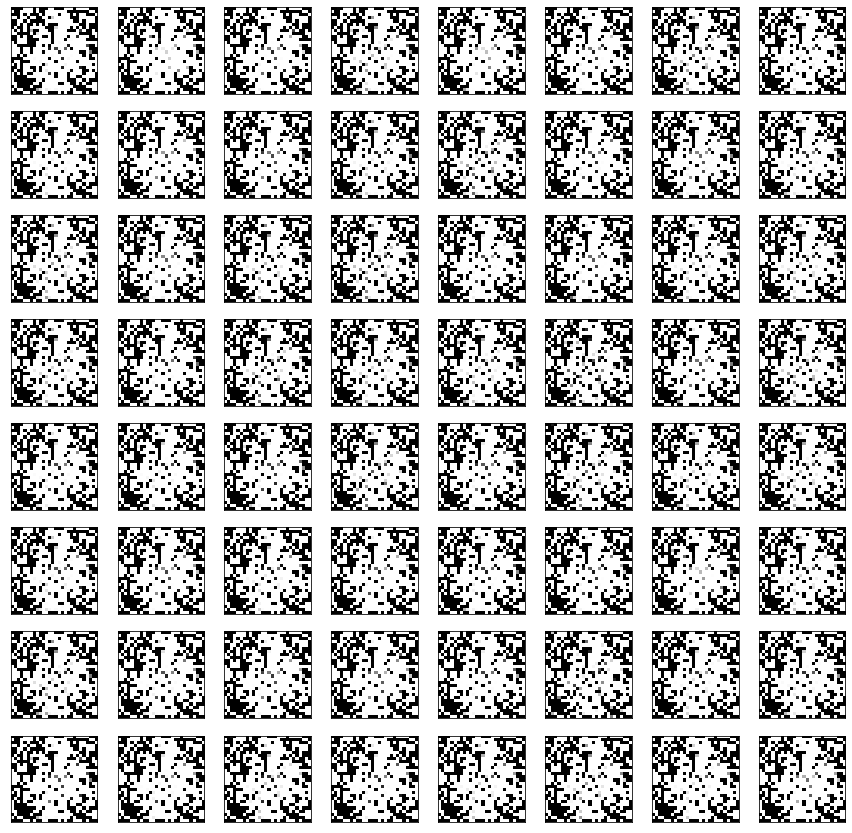

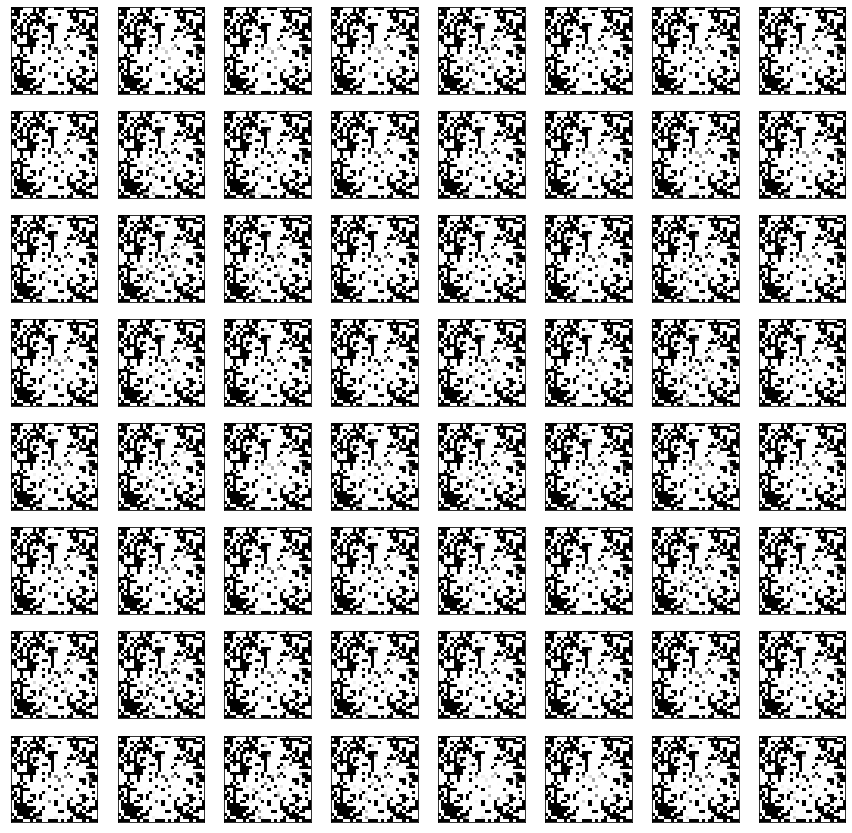

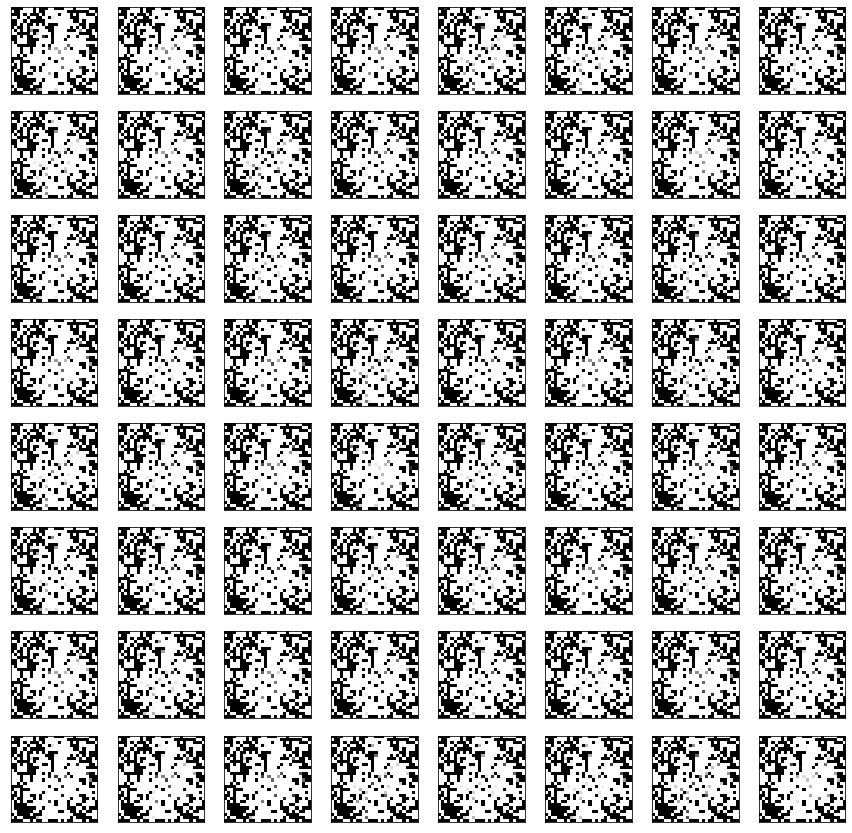

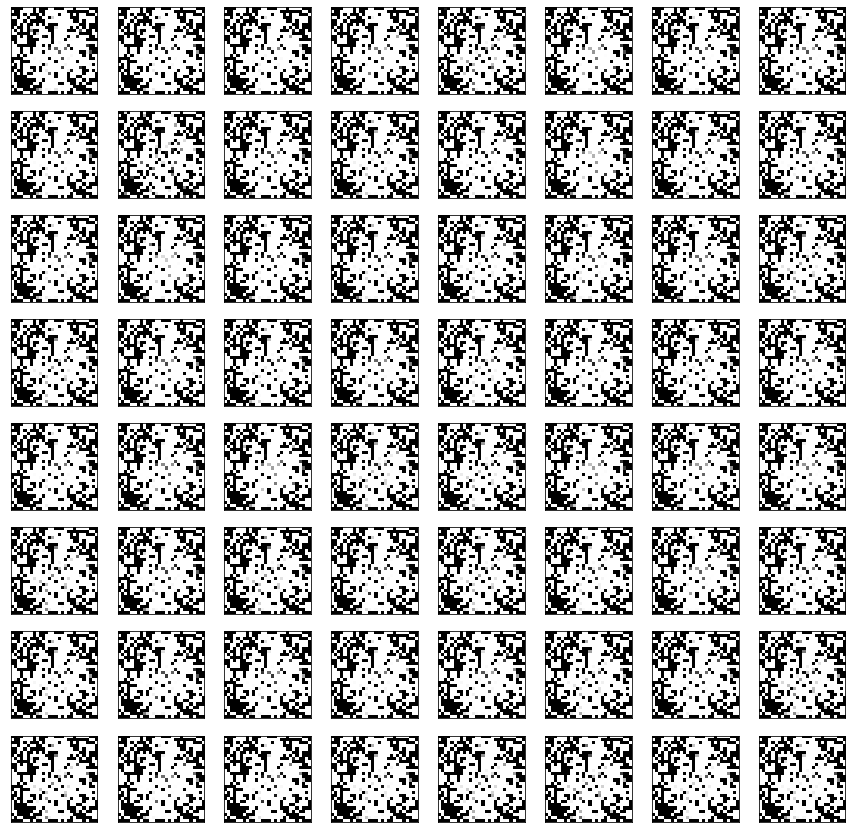

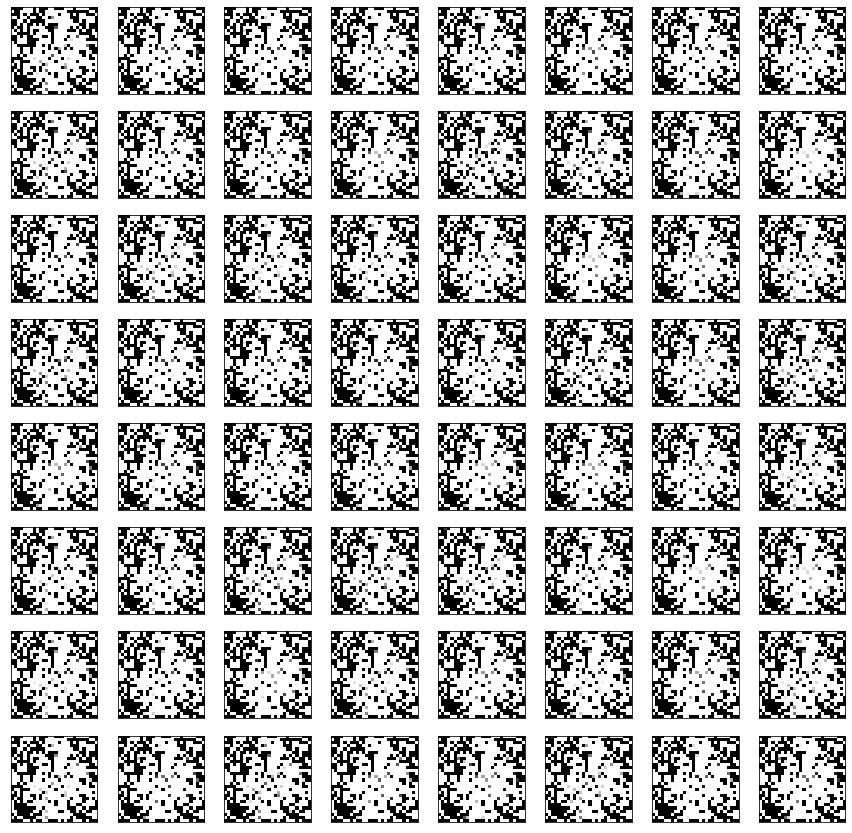

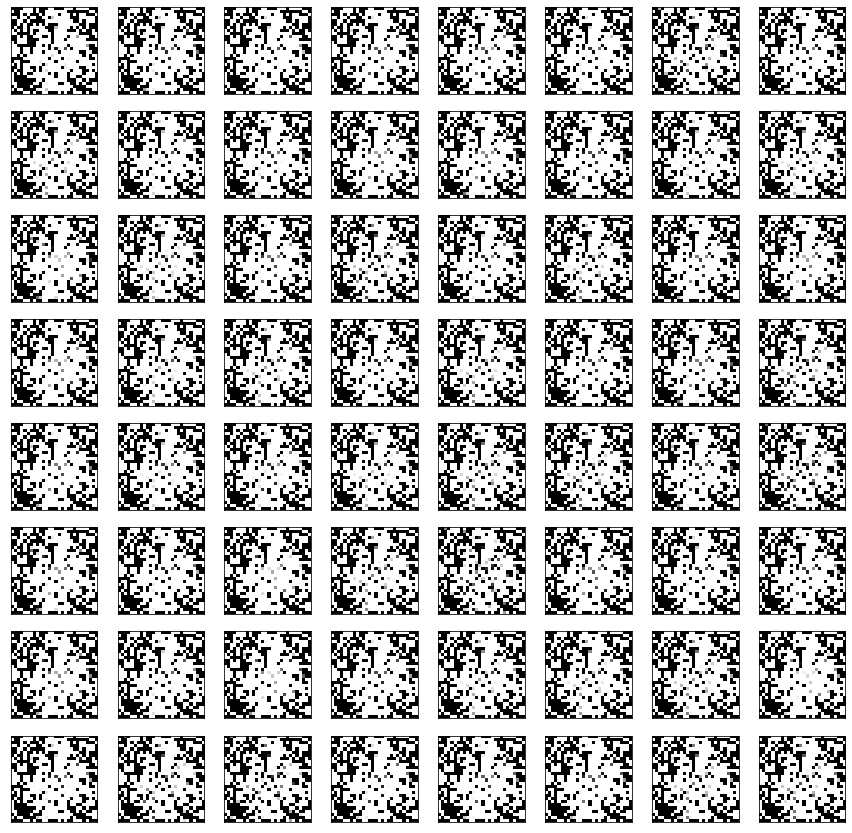

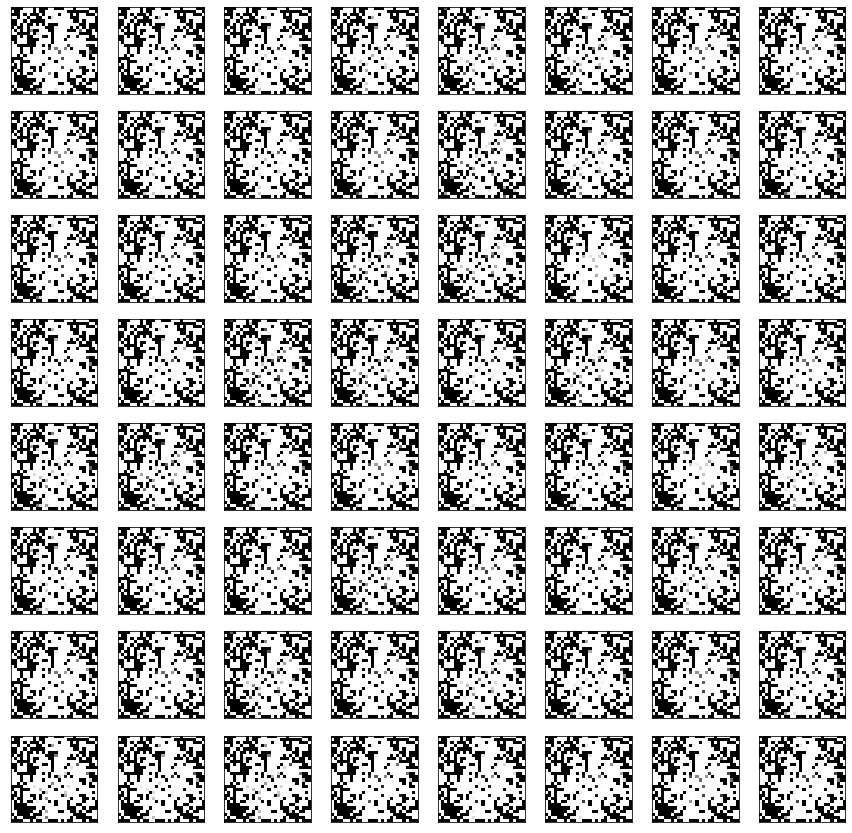

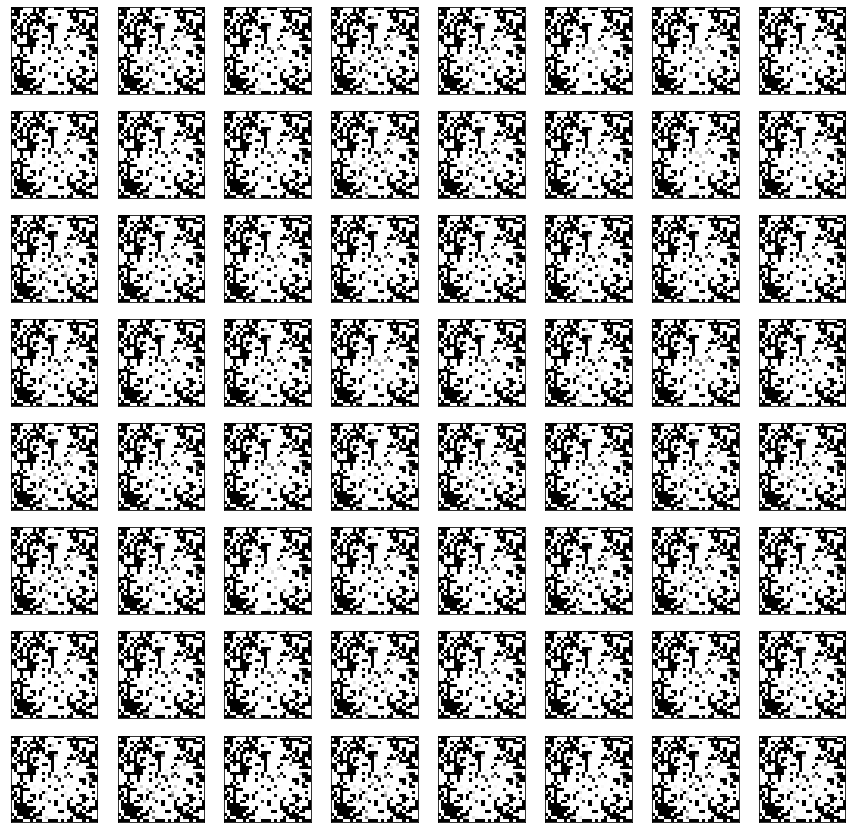

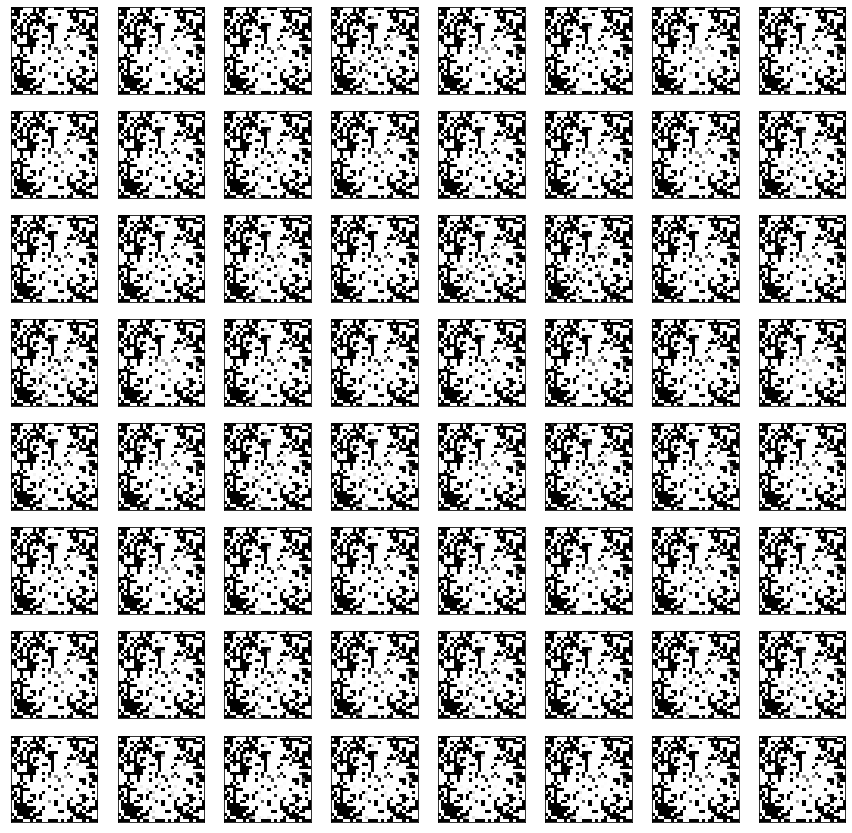

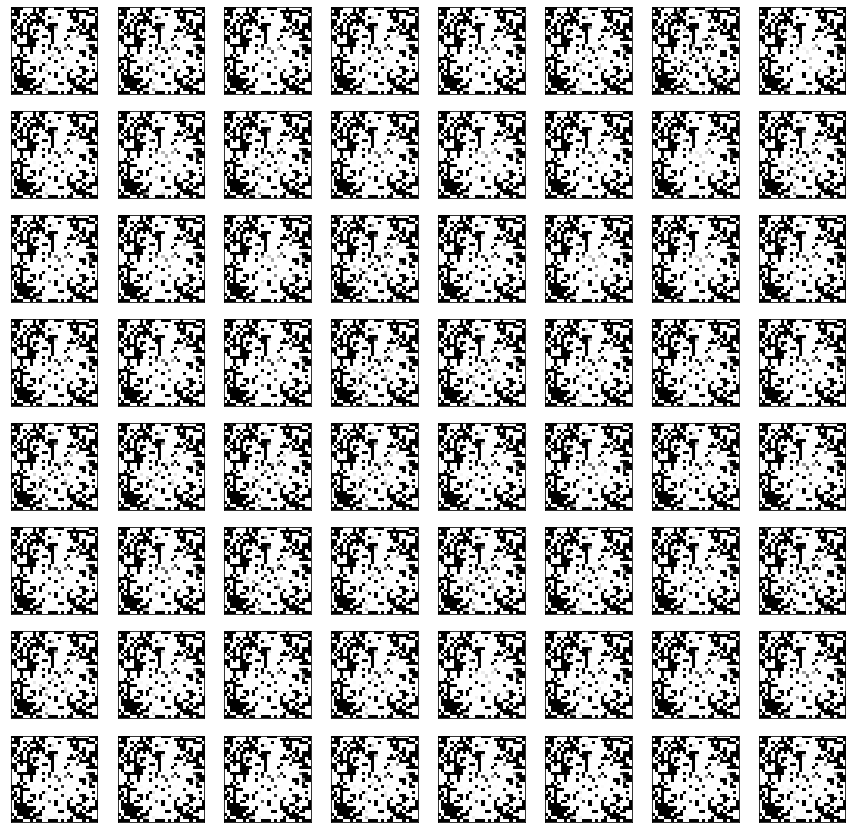

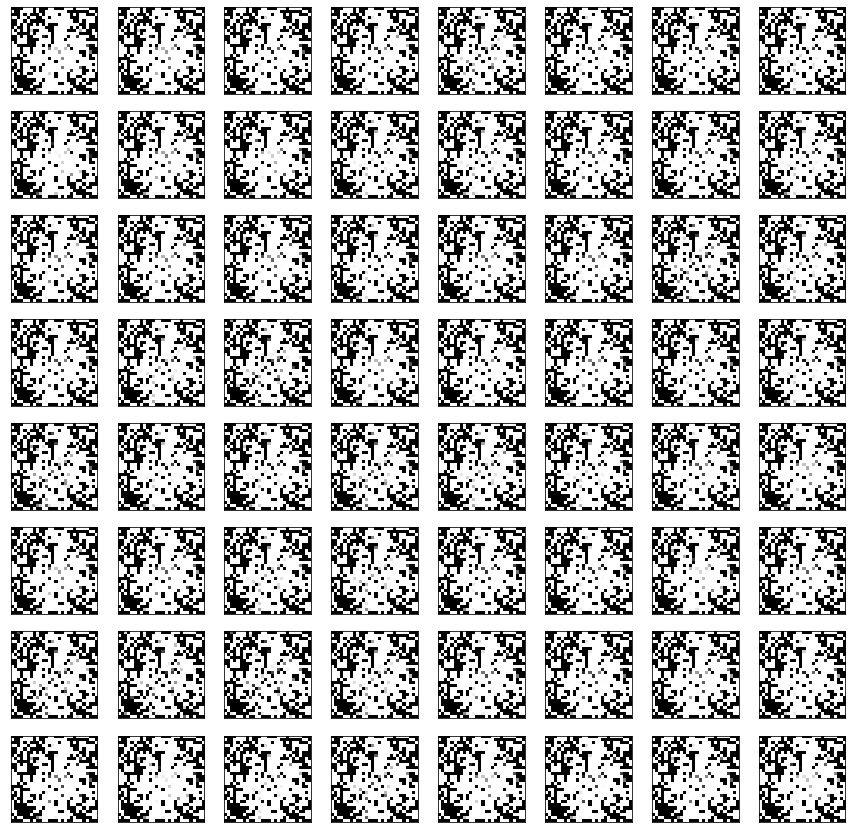

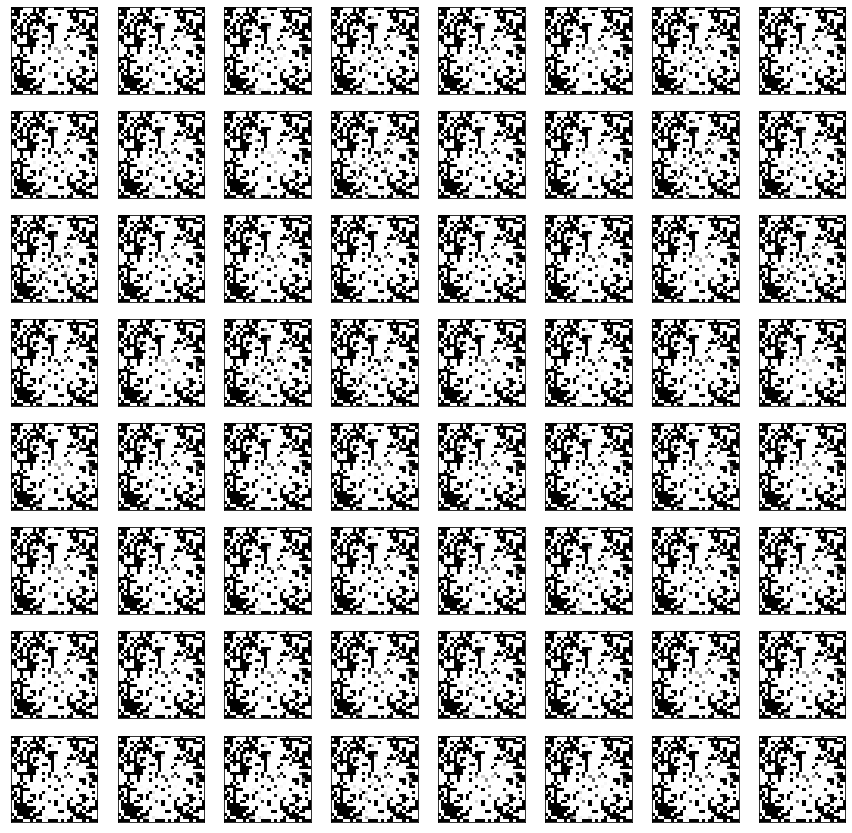

In [ ]:
# GAN.py
""":
Deep Learning Assignment 3
Conditional GAN Skeleton Code.
Adopted from public sources, customized and improved for this assignment.
"""

#import necessary modules
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim
from torch.autograd import Variable
# for visualization
from matplotlib import pyplot as plt
import math
import numpy as np

# tells PyTorch to use an NVIDIA GPU, if one is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading the dataset
training_parameters = {
    "img_size": 28,
    "n_epochs":24,
    "batch_size": 64,
    "learning_rate_generator": 0.0002,
    "learning_rate_discriminator": 0.0002,
}
# define a transform to 1) scale the images and 2) convert them into tensors
transform = transforms.Compose([
    transforms.Resize(training_parameters['img_size']), # scales the smaller edge of the image to have this size
    transforms.ToTensor(),
])

# load the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './data', # specifies the directory to download the datafiles to, relative to the location of the notebook.
        train = True,
        download = True,
        transform = transform),
    batch_size = training_parameters["batch_size"],
    shuffle=True
    )

# Fashion MNIST has 10 classes, just like MNIST. Here's what they correspond to:
label_descriptions = {
      0: 'T-shirt/top',
      1	: 'Trouser',
      2	: 'Pullover',
      3	: 'Dress',
      4	: 'Coat',
      5	: 'Sandal',
      6	: 'Shirt',
      7	: 'Sneaker',
      8	: 'Bag',
      9	: 'Ankle boot'
}

# Create the Generator model class, which will be used to initialize the generator
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim, num_labels=10): # to initialize the model-wide parameters. When you run `generator = Generator(params)`, those "params" are passed to __init__.
    super(Generator,self).__init__() # initialize the parent class
    # TODO (5.4) Turn this Generator into a Conditional Generator by
    # 1. Adjusting the input dimension of the first hidden layer.
    # 2. Modifying the input to the first hidden layer in the forward class.
    # self.label_embedding = nn.Embedding(10, 10) # This function will be useful.
    self.hidden_layer1 = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer3 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer4 = nn.Sequential(
        nn.Linear(1024, output_dim),
        nn.Tanh()
    )
  def forward(self, x, labels = None):
      # emb = self.label_embedding(labels)
      # import pdb; pdb.set_trace()
      # x = torch.cat((x, emb))
      # x = torch.cat((self.label_embedding(labels).squeeze(), x), -1)
      output = self.hidden_layer1(x)
      output = self.hidden_layer2(output)
      output = self.hidden_layer3(output)
      output = self.hidden_layer4(output)
      return output.to(device)

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_labels=None):
        super(Discriminator, self).__init__()
        # TODO (5.4) Modify this discriminator to function as a conditional discriminator.
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels=None): # labels to be used in 5.4.
        output = self.hidden_layer1(x.view(x.size(0), -1))
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)


discriminator = Discriminator(784,1).to(device) # initialize both models, and load them to the GPU or CPU.
generator = Generator(100,784).to(device)

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=training_parameters['learning_rate_discriminator'])
generator_optimizer = optim.Adam(generator.parameters(), lr=training_parameters['learning_rate_generator'])

# TODO: Implement the GAN training procedure.
loss = nn.BCELoss() 
def train_generator(batch_size):
    """
    Performs a training step on the generator by
        1. Generating fake images from random noise.
        2. Running the discriminator on the fake images.
        3. Computing loss on the result.
    :arg batch_size: the number of training examples in the current batch
    Returns the average generator loss over the batch.
    """
    # TODO: This function should perform a single training step on the generator
    # Start by zeroing the gradients of the optimizer
    generator_optimizer.zero_grad()
    # 1. Create a new batch of fake images (since the discriminator has just been trained on the old ones)
    noise = torch.randn(batch_size,100).to(device) # whenever you create new variables for the model to process, send them to the device, like this.
    gen_labels = Variable(torch.randint(low = 0, high = 10, size = (batch_size, 1), dtype = torch.long)).to(device)
    fake_data = generator(noise)

    y_real = Variable(torch.ones(batch_size, 1, device = device))

    pred_y = discriminator(fake_data, gen_labels)
    gen_loss = loss(pred_y, y_real)

    gen_loss.backward()
    generator_optimizer.step()

    return gen_loss.item()

def train_discriminator(batch_size, images, labels=None): # labels to be used in 5.4.
    """
    Performs a training step on the discriminator by
        1. Generating fake images from random noise.
        2. Running the discriminator on the fake images.
        3. Running the discriminator on the real images
        3. Computing loss on the results.
    :arg batch_size: the number of training examples in the current batch
    :arg images: the current batch of images, a tensor of size BATCH x 1 x 64 x 64
    :arg labels: the labels corresponding to images, a tensor of size BATCH
    Returns the average loss over the batch.
    """
    # TODO: And this function should perform a single training step on the discriminator
    discriminator_optimizer.zero_grad()
    y_real = Variable(torch.ones(batch_size, 1, device = device, dtype = torch.long))
    y_fake = Variable(torch.zeros(batch_size, 1, device = device, dtype = torch.long))

    pred_y_real = discriminator(images)
    real_loss = loss(pred_y_real.float(), y_real.float())

    noise = torch.randn(batch_size,100).to(device) # whenever you create new variables for the model to process, send them to the device, like this.
    fake_data = generator(noise)

    pred_y_fake = discriminator(fake_data.detach(), y_fake)
    fake_loss = loss(pred_y_fake.float(), y_fake.float())

    total_loss = (real_loss + fake_loss) / 2

    total_loss.backward()
    discriminator_optimizer.step()
    return total_loss.item()


for epoch in range(training_parameters['n_epochs']):
    G_loss = []  # for plotting the losses over time
    D_loss = []
    for batch, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size = labels.shape[0]  # if the batch size doesn't evenly divide the dataset length, this may change on the last epoch.
        for _ in range(3):
          lossG = train_generator(batch_size)
        G_loss.append(lossG)
        lossD = train_discriminator(batch_size, imgs, labels)
        D_loss.append(lossD)

        if ((batch + 1) % 500 == 0 and (epoch + 1) % 1 == 0):
            # Display a batch of generated images and print the loss
            print("Training Steps Completed: ", batch * epoch)
            with torch.no_grad():  # disables gradient computation to speed things up
                noise = torch.randn(batch_size, 100).to(device)
                fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)

                # display generated images
                batch_sqrt = int(training_parameters['batch_size'] ** 0.5)
                fig, ax = plt.subplots(batch_sqrt, batch_sqrt, figsize=(15, 15))
                for i, x in enumerate(generated_data):
                    # ax[math.floor(i / batch_sqrt)][i % batch_sqrt].set_title(
                    #     label_descriptions[int(fake_labels[i].item())]) # TODO: In 5.4 you can uncomment this line to add labels to images.
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].imshow(x.detach().numpy(), interpolation='nearest',
                                                                          cmap='gray')
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].get_xaxis().set_visible(False)
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].get_yaxis().set_visible(False)
                # plt.show()
                fig.savefig(f"./results/GAN_Generations_Epoch_{epoch}")
                print(
                    f"Epoch {epoch}: loss_d: {torch.mean(torch.FloatTensor(D_loss))}, loss_g: {torch.mean(torch.FloatTensor(G_loss))}")

### 5.3
Experiment with the hyperparameters of your GAN to try to produce the best-quality images possible. What happens if you use different learning rates for the discriminator and generator, or if you train the generator multiple times for every iteration of the discriminator? Describe the best training scheme, and any problems you encountered during training. Include sample generations in your report.

Please see the pdf file.

### 5.4
The standard GAN is an unsupervised model, but the Conditional GAN provides the generator and discriminator with image labels. This allows a Conditional GAN to generate images from a specific class on demand, and enables the discriminator to penalize generated images which deviate from their labels. Follow the TODOs in the Generator and Discriminator classes to turn your GAN into a Conditional GAN.

### 5.5
Run your Conditional GAN on Fashion MNIST. How do these generated images compare to your initial GAN, both in quality and in the relative abundance of each class?

In [ ]:
!mkdir results

In [ ]:
# cGAN.py
""":
Deep Learning Assignment 3
Conditional GAN Skeleton Code.
Adopted from public sources, customized and improved for this assignment.
"""

#import necessary modules
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim
from torch.autograd import Variable
# for visualization
from matplotlib import pyplot as plt
import math
import numpy as np

# tells PyTorch to use an NVIDIA GPU, if one is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading the dataset
training_parameters = {
    "img_size": 28,
    "n_epochs": 100,
    "batch_size": 64,
    "learning_rate_generator": 0.0002,
    "learning_rate_discriminator": 0.0002,
}
# define a transform to 1) scale the images and 2) convert them into tensors
transform = transforms.Compose([
    transforms.Resize(training_parameters['img_size']), # scales the smaller edge of the image to have this size
    transforms.ToTensor(),
])

# load the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './data', # specifies the directory to download the datafiles to, relative to the location of the notebook.
        train = True,
        download = True,
        transform = transform),
    batch_size = training_parameters["batch_size"],
    shuffle=True
    )

# Fashion MNIST has 10 classes, just like MNIST. Here's what they correspond to:
label_descriptions = {
      0: 'T-shirt/top',
      1	: 'Trouser',
      2	: 'Pullover',
      3	: 'Dress',
      4	: 'Coat',
      5	: 'Sandal',
      6	: 'Shirt',
      7	: 'Sneaker',
      8	: 'Bag',
      9	: 'Ankle boot'
}

# Create the Generator model class, which will be used to initialize the generator
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim, num_labels=10): # to initialize the model-wide parameters. When you run `generator = Generator(params)`, those "params" are passed to __init__.
    super(Generator,self).__init__() # initialize the parent class
    # TODO (5.4) Turn this Generator into a Conditional Generator by
    # 1. Adjusting the input dimension of the first hidden layer.
    # 2. Modifying the input to the first hidden layer in the forward class.
    # self.label_embedding = nn.Embedding(10, 10) # This function will be useful.
    self.label_embedding = nn.Embedding(10, 10)
    self.hidden_layer1 = nn.Sequential(
        nn.Linear(input_dim + num_labels, 256),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer3 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2)
    )
    self.hidden_layer4 = nn.Sequential(
        nn.Linear(1024, output_dim),
        nn.Tanh()
    )
  def forward(self, x, labels):
      # emb = self.label_embedding(labels)
      # import pdb; pdb.set_trace()
      # x = torch.cat((x, emb))
      x = torch.cat((x, self.label_embedding(labels).squeeze()), -1)
      output = self.hidden_layer1(x)
      output = self.hidden_layer2(output)
      output = self.hidden_layer3(output)
      output = self.hidden_layer4(output)
      return output.to(device)

class Discriminator(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_labels=None):
        super(Discriminator, self).__init__()
        # TODO (5.4) Modify this discriminator to function as a conditional discriminator.
        self.label_embedding = nn.Embedding(10, 10)
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim + num_labels, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels=None): # labels to be used in 5.4.
        x = torch.cat((x.view(x.size(0), -1), self.label_embedding(labels).squeeze()), -1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)


discriminator = Discriminator(784,1, 10).to(device) # initialize both models, and load them to the GPU or CPU.
generator = Generator(100,784, 10).to(device)

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=training_parameters['learning_rate_discriminator'])
generator_optimizer = optim.Adam(generator.parameters(), lr=training_parameters['learning_rate_generator'])

# TODO: Implement the GAN training procedure.
loss = nn.BCELoss() 
def train_generator(batch_size):
    """
    Performs a training step on the generator by
        1. Generating fake images from random noise.
        2. Running the discriminator on the fake images.
        3. Computing loss on the result.
    :arg batch_size: the number of training examples in the current batch
    Returns the average generator loss over the batch.
    """
    # TODO: This function should perform a single training step on the generator
    # Start by zeroing the gradients of the optimizer
    generator_optimizer.zero_grad()
    # 1. Create a new batch of fake images (since the discriminator has just been trained on the old ones)
    noise = torch.randn(batch_size,100).to(device) # whenever you create new variables for the model to process, send them to the device, like this.
    gen_labels = Variable(torch.randint(low = 0, high = 10, size = (batch_size,), dtype = torch.long)).to(device)

    fake_data = generator(noise, gen_labels)

    y_real = Variable(torch.ones(batch_size, 1, device = device, dtype = torch.long))

    pred_y = discriminator(fake_data, gen_labels)
    gen_loss = loss(pred_y.float(), y_real.float())

    gen_loss.backward()
    generator_optimizer.step()

    return gen_loss.item()

def train_discriminator(batch_size, images, labels=None): # labels to be used in 5.4.
    """
    Performs a training step on the discriminator by
        1. Generating fake images from random noise.
        2. Running the discriminator on the fake images.
        3. Running the discriminator on the real images
        3. Computing loss on the results.
    :arg batch_size: the number of training examples in the current batch
    :arg images: the current batch of images, a tensor of size BATCH x 1 x 64 x 64
    :arg labels: the labels corresponding to images, a tensor of size BATCH
    Returns the average loss over the batch.
    """
    # TODO: And this function should perform a single training step on the discriminator
    discriminator_optimizer.zero_grad()
    y_real = Variable(torch.ones(batch_size, 1, device = device, dtype = torch.long))
    y_fake = Variable(torch.zeros(batch_size, 1, device = device, dtype = torch.long))

    pred_y_real = discriminator(images, labels)
    real_loss = loss(pred_y_real.float(), y_real.float())

    noise = torch.randn(batch_size,100).to(device) # whenever you create new variables for the model to process, send them to the device, like this.
    gen_labels = Variable(torch.randint(low = 0, high = 10, size = (batch_size,), dtype = torch.long)).to(device)
    fake_data = generator(noise, gen_labels.squeeze())

    pred_y_fake = discriminator(fake_data.detach(), gen_labels)
    fake_loss = loss(pred_y_fake.float(), y_fake.float())

    total_loss = (real_loss + fake_loss) / 2

    total_loss.backward()
    discriminator_optimizer.step()
    return total_loss.item()


for epoch in range(training_parameters['n_epochs']):
    G_loss = []  # for plotting the losses over time
    D_loss = []
    for batch, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size = labels.shape[0]  # if the batch size doesn't evenly divide the dataset length, this may change on the last epoch.
        lossG = train_generator(batch_size)
        G_loss.append(lossG)
        lossD = train_discriminator(batch_size, imgs, labels)
        D_loss.append(lossD)

        if ((batch + 1) % 500 == 0 and (epoch + 1) % 1 == 0):
            # Display a batch of generated images and print the loss
            print("Training Steps Completed: ", batch * epoch)
            with torch.no_grad():  # disables gradient computation to speed things up
                noise = torch.randn(batch_size, 100).to(device)
                fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)

                # display generated images
                batch_sqrt = int(training_parameters['batch_size'] ** 0.5)
                fig, ax = plt.subplots(batch_sqrt, batch_sqrt, figsize=(15, 15))
                for i, x in enumerate(generated_data):
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].set_title(
                        label_descriptions[int(fake_labels[i].item())]) # TODO: In 5.4 you can uncomment this line to add labels to images.
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].imshow(x.detach().numpy(), interpolation='nearest',
                                                                          cmap='gray')
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].get_xaxis().set_visible(False)
                    ax[math.floor(i / batch_sqrt)][i % batch_sqrt].get_yaxis().set_visible(False)
                # plt.show()
                fig.savefig(f"./results/CGAN_Generations_Epoch_{epoch}")
                print(
                    f"Epoch {epoch}: loss_d: {torch.mean(torch.FloatTensor(D_loss))}, loss_g: {torch.mean(torch.FloatTensor(G_loss))}")

Training Steps Completed:  0
Epoch 0: loss_d: 0.6001885533332825, loss_g: 1.2964286804199219
Training Steps Completed:  499
Epoch 1: loss_d: 0.5644525289535522, loss_g: 1.634354829788208
Training Steps Completed:  998
Epoch 2: loss_d: 0.5190479755401611, loss_g: 1.452103853225708
Training Steps Completed:  1497
Epoch 3: loss_d: 0.5108046531677246, loss_g: 1.4923186302185059
Training Steps Completed:  1996
Epoch 4: loss_d: 0.5291593074798584, loss_g: 1.306198000907898
Training Steps Completed:  2495
Epoch 5: loss_d: 0.581081748008728, loss_g: 1.235992670059204
Training Steps Completed:  2994
Epoch 6: loss_d: 0.5635131001472473, loss_g: 1.117133617401123
Training Steps Completed:  3493
Epoch 7: loss_d: 0.5576332807540894, loss_g: 1.148931622505188
Training Steps Completed:  3992
Epoch 8: loss_d: 0.5667716264724731, loss_g: 1.174591302871704
Training Steps Completed:  4491
Epoch 9: loss_d: 0.6068589687347412, loss_g: 1.0568499565124512
Training Steps Completed:  4990
Epoch 10: loss_d: 0.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 20: loss_d: 0.571399450302124, loss_g: 1.1597301959991455
Training Steps Completed:  10479
Epoch 21: loss_d: 0.53920578956604, loss_g: 1.225912094116211


### 5.6
Describe the theoretical differences between a generative adversarial network (GAN) and a variational autoencoder (VAE). What differences did you notice in practice? What tasks would be more suited for a VAE, and what tasks require a GAN?

The difference between a VAE and a GAN is as follows. VAE is a probabilistic graphical model that assumes a latent variable that generates the observed data. It tries to maximize the evidence lower bound which can be implemented by an autoencoder. GAN is explicitly designed for generative tasks with a generator to generate samples and a discriminator to force the generator to generate authentic samples. 

In practice, VAEs can be compared by evaluating the evidence lower bounds and comparing them while GANs can not. GANs are more difficult to train. In our case, the images reconstructed from the VAE seem to be much more clear. However, with the GANs we can see a design starting to form in the clothing, something that the VAE doesn’t do particularly well. In the case of the GAN, it seems even the background is not learned to be a solid color, which is something the VAE does very well. In an applied setting, each has their own merits. If one is trying to get new clothing ideas, a GAN would be better, particularly a cGAN, as you can specify the category to create.

VAE is suitable for tasks where we know there are some latent variables underlying the observed data. GAN is suitable for generating realistic images.

### 5.7
Why do we often choose the input to a GAN (z) to be samples from a Gaussian? Can you think of any potential problems with this?


The reason of using a Gaussian is probably simplicity. 

The problem is that the data distribution could be on a low dimensional manifold (embedded in a high dimensional space) whose dimension may not match the dimension of a Gaussian.



### 5.8
In class we talked about using GANs for the problem of mapping from one domain to another (e.g. faces with black hair to faces with blond hair). A simple model for this would learn two generators: one that takes the first domain as input and produces output in the second domain as judged by a discriminator,and vice versa for the other domain. What are some of the reasons the DiscoGAN/CycleGAN perform better at this task than the simpler model?

For DiscoGAN, the two generators are not independent. They are coupled together learns the mapping from one domain to another, and also the reverse mapping to for reconstruction. The two models are trained together simultaneously. The two generators $G_{AB}$'s and the two generators $G_{BA}$'s share parameters, and the generated images $x_{BA}$ and $x_{AB}$ are each fed into seperate discriminators $L_{D_A}$ and $L_{D_B}$, respectively. The input images from both domains are reconstructed. The model is constrained by two $L_{GAN}$ losses and two $L_{CONST}$ losses. Therefore, a bijective mapping is achieved and cross-domain relation can be discovered. 

For CycleGAN, it's cycle consistent. That means if we have a
translator $G: X \rightarrow Y$ and another translator $F: Y \rightarrow X$,
then $G$ and $F$ should be inverses of each other, and both
mappings should be bijections. 